In [1]:
# libraries for data exploration.
import pandas as pd
import numpy as np
import seaborn as sns
import math

# library for splitting data.
from sklearn.model_selection import train_test_split

# libraries for preparing the data.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# libraries for building linear models.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# library for measuring error. 
from sklearn.metrics import mean_squared_error

# time series specific libararies
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.offsetbox import AnchoredText
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# user defined.
from helpful_functions import MLFunctions
from plot_setup import *

In [2]:
# load sales data.
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    usecols=['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'],
                    index_col='date')

In [3]:
sales.index = pd.to_datetime(sales.index, format="%d.%m.%Y")
#sales.index = sales.index.to_period('D')
sales = sales.sort_index()

In [4]:
sales.head()

,shop_id,item_id,item_price,item_cnt_day
date,,,,
2013-01-01,18,5823,2500.0,1.0
2013-01-01,27,5573,849.0,1.0
2013-01-01,7,1006,399.0,1.0
2013-01-01,19,17707,899.0,1.0
2013-01-01,14,19548,149.0,1.0


In [5]:
exploration_data = sales.loc[:,['item_cnt_day']].groupby('date').sum()

,item_cnt_day
date,
2013-01-01,1951.0
2013-01-02,8198.0
2013-01-03,7422.0
2013-01-04,6617.0
2013-01-05,6346.0


In [10]:
helper_function = MLFunctions(exploration_data)
arr = helper_function.dateNum()

In [12]:
exploration_data['time'] = arr

In [14]:
exploration_data.head()

,item_cnt_day,time
date,,
2013-01-01,1951.0,0
2013-01-02,8198.0,1
2013-01-03,7422.0,2
2013-01-04,6617.0,3
2013-01-05,6346.0,4


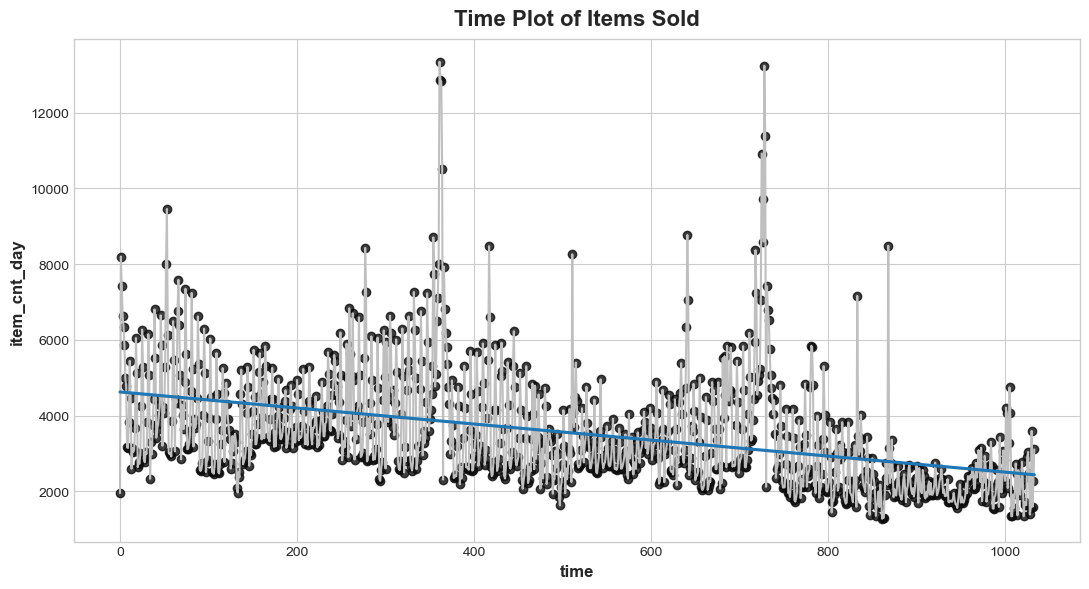

In [18]:
fig, ax = plt.subplots()
ax.plot('time', 'item_cnt_day', data=exploration_data, color='0.75')
ax = sns.regplot(x='time', y='item_cnt_day', data=exploration_data, ci=None, scatter_kws=dict(color='0.05'))
ax.set_title('Time Plot of Items Sold');

In [27]:
sales['lag_1'] = sales['item_cnt_day'].shift(1)
sales['lag_2'] = sales['item_cnt_day'].shift(2)
sales['lag_3'] = sales['item_cnt_day'].shift(3)
sales['lag_5'] = sales['item_cnt_day'].shift(5)
sales['lag_6'] = sales['item_cnt_day'].shift(6)
sales['lag_7'] = sales['item_cnt_day'].shift(7)
sales['lag_8'] = sales['item_cnt_day'].shift(8)

In [29]:
sales.head()

item_price  item_cnt_day  time  lag_1  lag_2  \
date       shop_id item_id                                                 
2013-01-01 2       991            99.0           1.0     0    NaN    NaN   
                   1472         2599.0           1.0     0    1.0    NaN   
                   1905          249.0           1.0     0    1.0    1.0   
                   2920          599.0           2.0     0    1.0    1.0   
                   3320         1999.0           1.0     0    2.0    1.0   

                            lag_3  lag_5  lag_6  lag_7  lag_8  
date       shop_id item_id                                     
2013-01-01 2       991        NaN    NaN    NaN    NaN    NaN  
                   1472       NaN    NaN    NaN    NaN    NaN  
                   1905       NaN    NaN    NaN    NaN    NaN  
                   2920       1.0    NaN    NaN    NaN    NaN  
                   3320       1.0    NaN    NaN    NaN    NaN

In [52]:
sales.unstack(['shop_id', 'item_id'])

item_price                                                       \
shop_id            2                                                         
item_id         991     1472   1905   2920    3320   4464    4724    5649    
date                                                                         
2013-01-01       99.0  2599.0  249.0  599.0  1999.0  599.0  1399.0  2190.0   
2013-01-02        NaN     NaN    NaN  598.5     NaN    NaN     NaN     NaN   
2013-01-03        NaN     NaN    NaN    NaN     NaN    NaN     NaN     NaN   
2013-01-04        NaN     NaN    NaN    NaN  1999.0  599.0     NaN     NaN   
2013-01-05        NaN     NaN  249.0  598.5     NaN    NaN     NaN     NaN   
...               ...     ...    ...    ...     ...    ...     ...     ...   
2015-10-27        NaN     NaN    NaN    NaN     NaN    NaN     NaN     NaN   
2015-10-28        NaN     NaN    NaN    NaN     NaN    NaN     NaN     NaN   
2015-10-29        NaN     NaN    NaN    NaN     NaN    NaN     NaN     NaN   
2015-10-30        NaN     NaN    NaN    NaN     NaN    NaN     NaN     NaN   
2015-10-31        NaN     NaN    NaN    NaN     NaN    NaN     NaN     NaN   

                          ... lag_8                                            \
shop_id                   ...    58                                  59         
item_id     6911   6916   ... 7135  14802 15706 16208 17388 17747 11710 15411   
date                      ...                                                   
2013-01-01  599.0  999.5  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2013-01-02    NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2013-01-03    NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2013-01-04  599.0    NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2013-01-05    NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...           ...    ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
2015-10-27    NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2015-10-28    NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2015-10-29    NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2015-10-30    NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2015-10-31    NaN    NaN  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

                        
shop_id                 
item_id    17755 17774  
date                    
2013-01-01   NaN   NaN  
2013-01-02   NaN   NaN  
2013-01-03   NaN   NaN  
2013-01-04   NaN   NaN  
2013-01-05   NaN   NaN  
...          ...   ...  
2015-10-27   NaN   NaN  
2015-10-28   NaN   NaN  
2015-10-29   NaN   NaN  
2015-10-30   NaN   NaN  
2015-10-31   1.0   1.0  

[1034 rows x 4241240 columns]

In [64]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(sales.item_cnt_day, lags=4)
X = X.fillna(0.0)

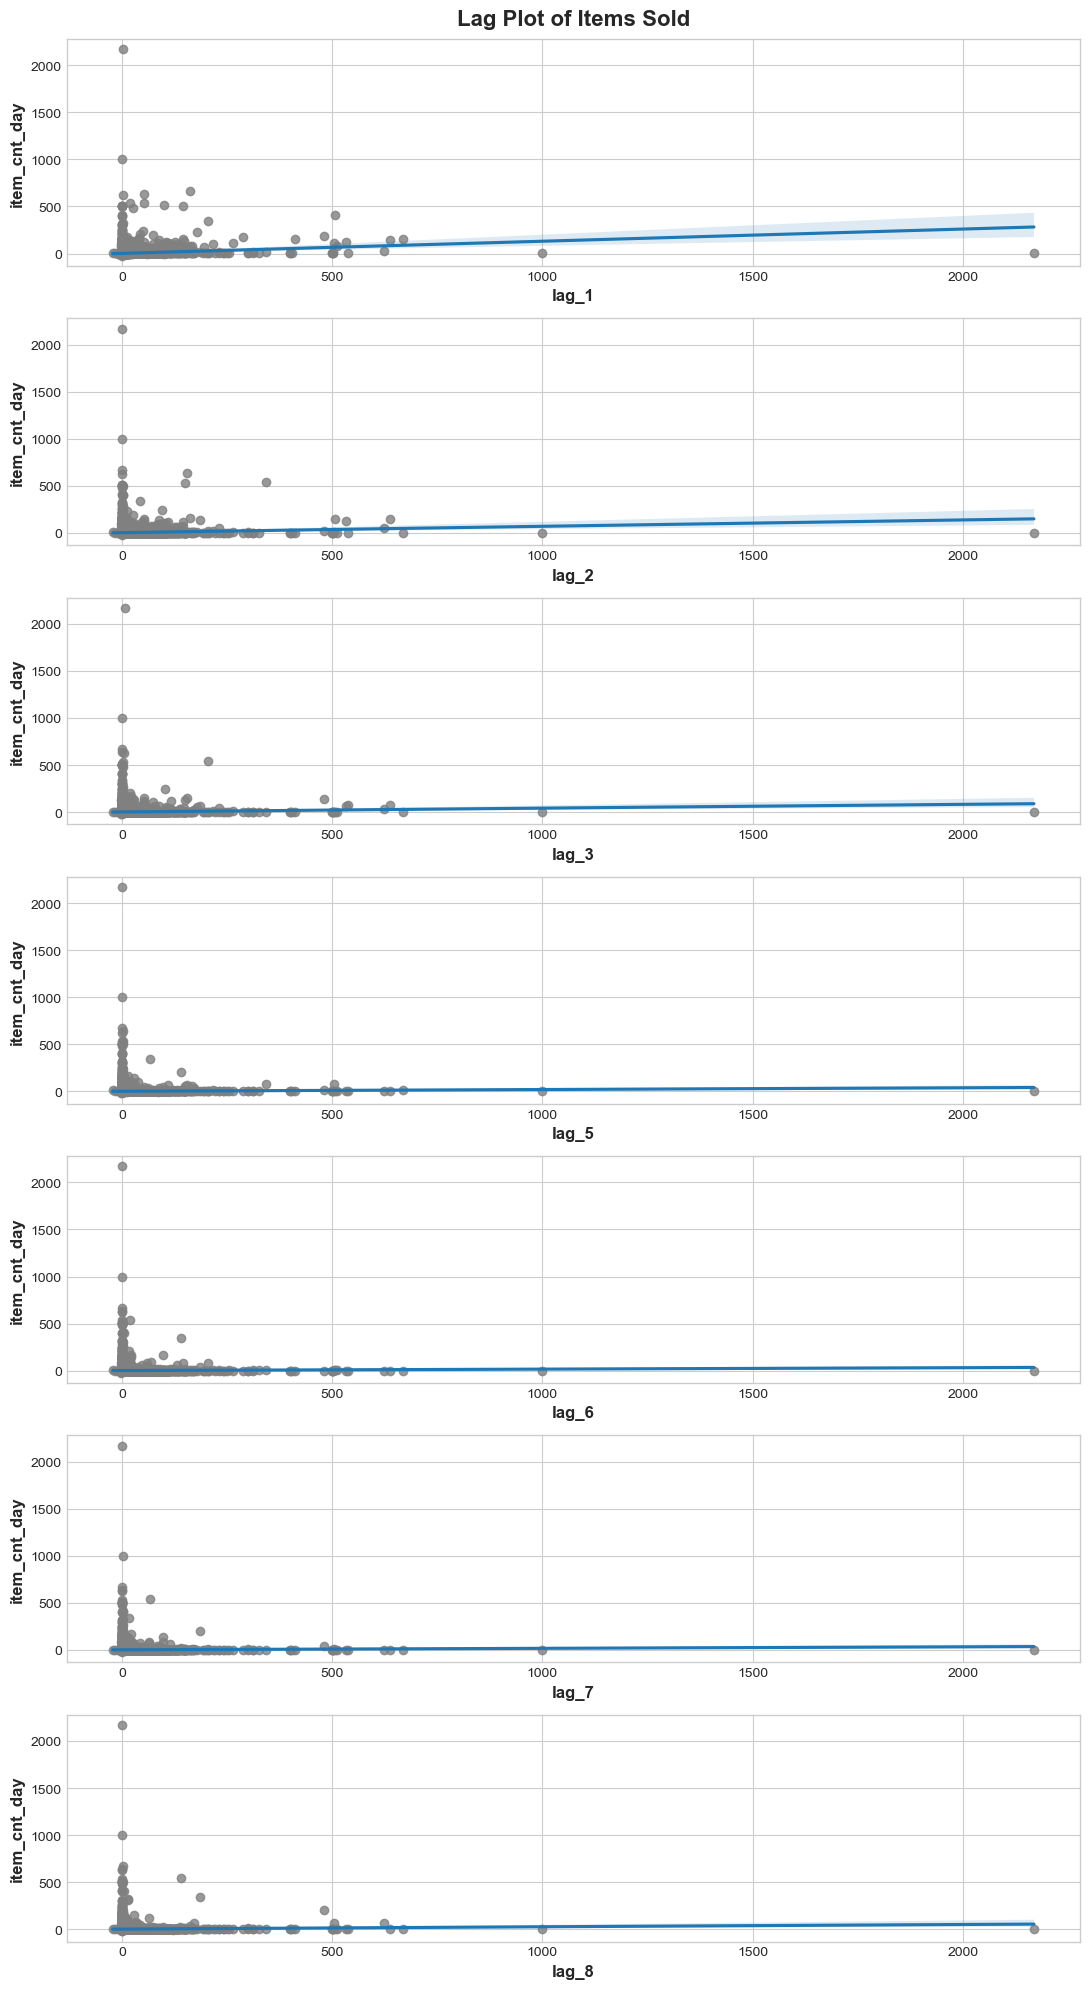

In [31]:
fig, (ax1,ax2,ax3,ax5,ax6,ax7,ax8) = plt.subplots(7,1, figsize=(11,20))
_ = sns.regplot(x='lag_1', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax1)
_ = sns.regplot(x='lag_2', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax2)
_ = sns.regplot(x='lag_3', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax3)
_ = sns.regplot(x='lag_5', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax5)
_ = sns.regplot(x='lag_6', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax6)
_ = sns.regplot(x='lag_7', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax7)
_ = sns.regplot(x='lag_8', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax8)
ax1.set_title('Lag Plot of Items Sold');

In [34]:
items_sold = sales.loc[:, ['item_cnt_day']]
trend = items_sold.rolling(window=90,
                           center=True,
                           min_periods=45).mean()

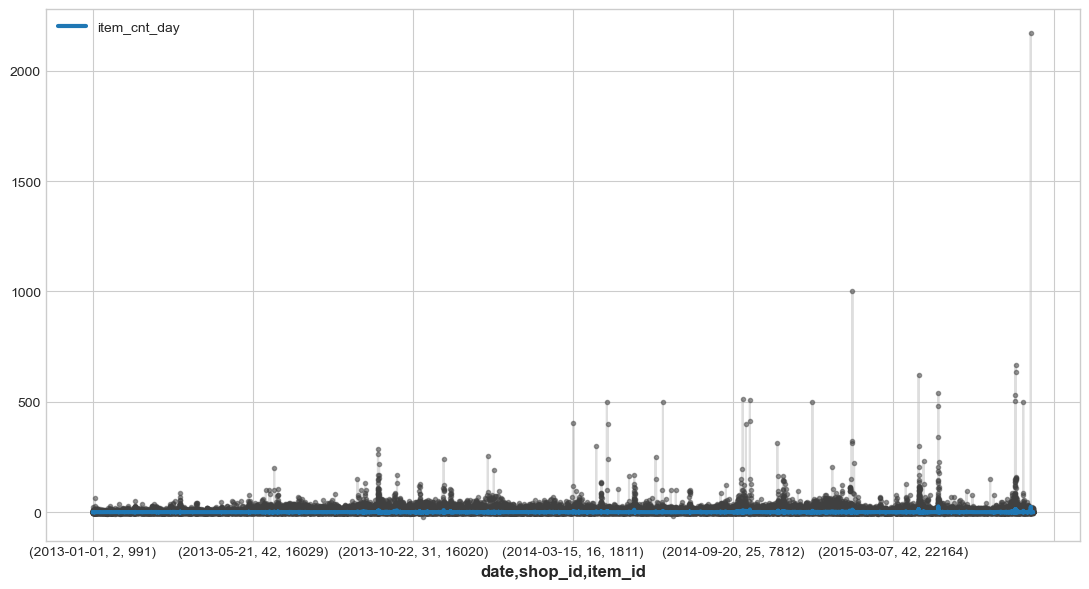

In [36]:
# Make a plot
ax = items_sold.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [25]:
# below code shows how fourier features are generated
'''
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)
fourier = fourier_features(sales.index, freq=365.25, order=4)
'''

'\ndef fourier_features(index, freq, order):\n    time = np.arange(len(index), dtype=np.float32)\n    k = 2 * np.pi * (1 / freq) * time\n    features = {}\n    for i in range(1, order + 1):\n        features.update({\n            f"sin_{freq}_{i}": np.sin(i * k),\n            f"cos_{freq}_{i}": np.cos(i * k),\n        })\n    return pd.DataFrame(features, index=index)\nfourier = fourier_features(sales.index, freq=365.25, order=4)\n'

In [37]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [38]:
X = sales.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="item_cnt_day", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="item_cnt_day", period="year", freq="dayofyear", ax=ax1);

AttributeError: 'MultiIndex' object has no attribute 'dayofweek'

In [51]:
X.head()

item_price  item_cnt_day  time  lag_1  lag_2  \
date       shop_id item_id                                                 
2013-01-01 2       991            99.0           1.0     0    NaN    NaN   
                   1472         2599.0           1.0     0    1.0    NaN   
                   1905          249.0           1.0     0    1.0    1.0   
                   2920          599.0           2.0     0    1.0    1.0   
                   3320         1999.0           1.0     0    2.0    1.0   

                            lag_3  lag_5  lag_6  lag_7  lag_8  
date       shop_id item_id                                     
2013-01-01 2       991        NaN    NaN    NaN    NaN    NaN  
                   1472       NaN    NaN    NaN    NaN    NaN  
                   1905       NaN    NaN    NaN    NaN    NaN  
                   2920       1.0    NaN    NaN    NaN    NaN  
                   3320       1.0    NaN    NaN    NaN    NaN

In [ ]:
X.tail()

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [ ]:
plot_periodogram(sales.item_cnt_day)

In [44]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [46]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

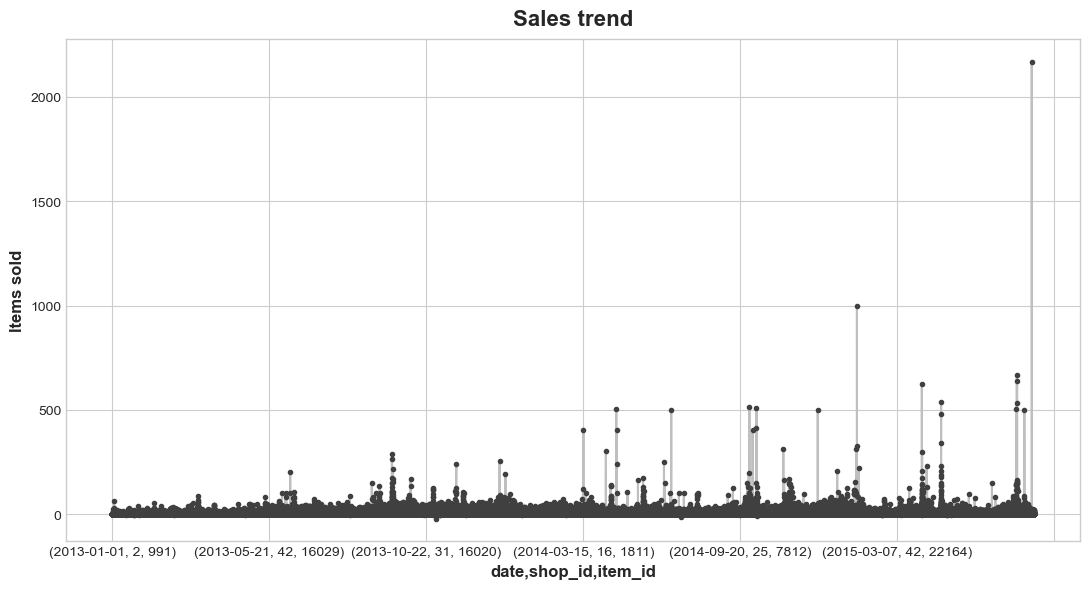

In [48]:
ax = sales.item_cnt_day.plot(title="Sales trend", **plot_params)
_ = ax.set(ylabel="Items sold")

C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


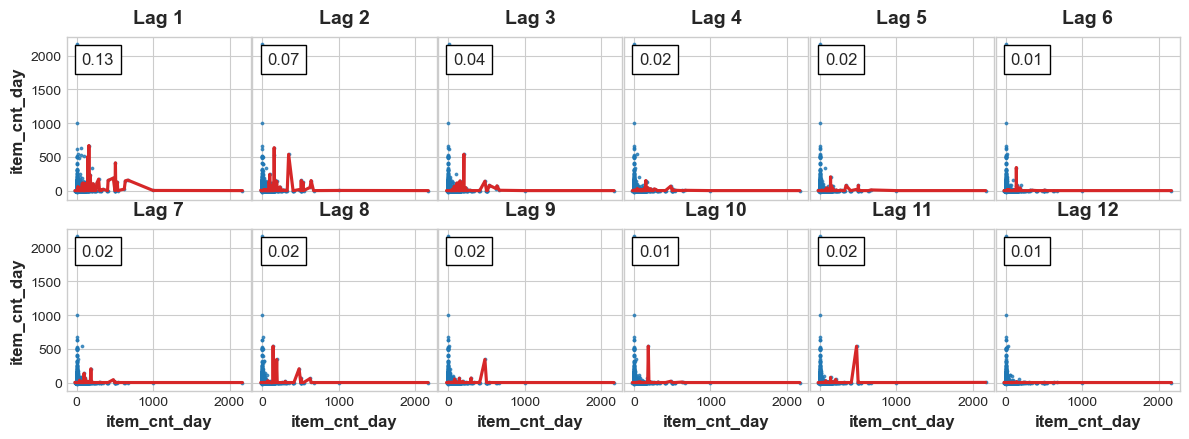

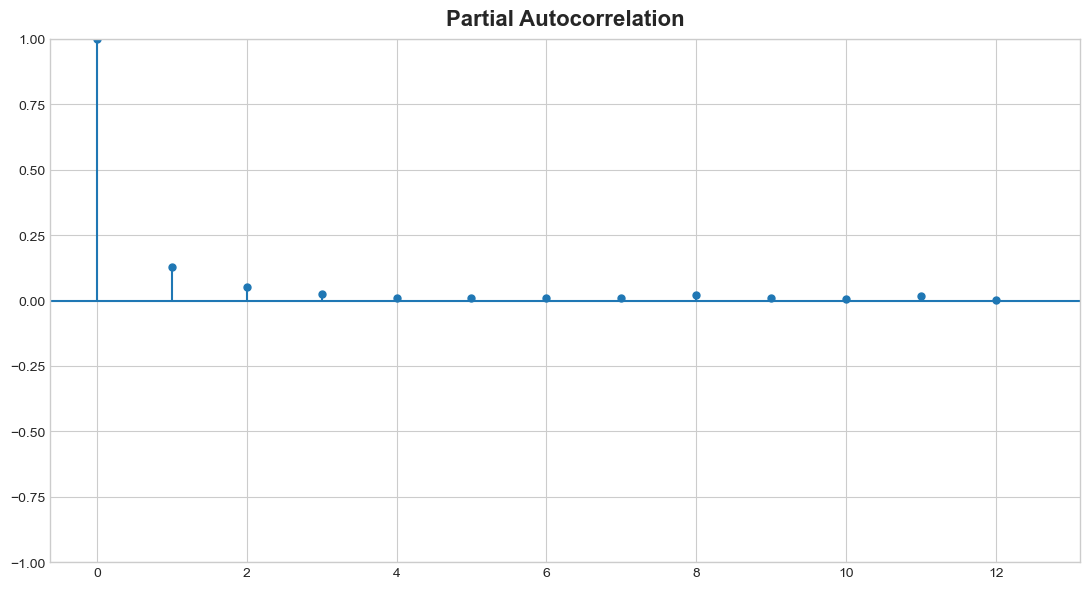

In [49]:
_ = plot_lags(sales.item_cnt_day, lags=12, nrows=2)
_ = plot_pacf(sales.item_cnt_day, lags=12)